Use T2I-Adapters for Stable Diffusion XL (SDXL) to mess with images, this episode: **sketch-guided**

Example:
![](https://camo.githubusercontent.com/e5fdc53a1c9b9ca2c500aacac2cde00fd5e5cd012a89ca0f7c62f607f17010e2/68747470733a2f2f68756767696e67666163652e636f2f416461707465722f743269616461707465722f7265736f6c76652f6d61696e2f745f736b657463682e504e47)

# Install the necessary packages
probably some missing ..

In [1]:
!pip freeze | egrep "diffusers|controlnet"

controlnet-aux==0.0.7
diffusers==0.23.1


# (Draw or) Load a sketch and convert to greyscale

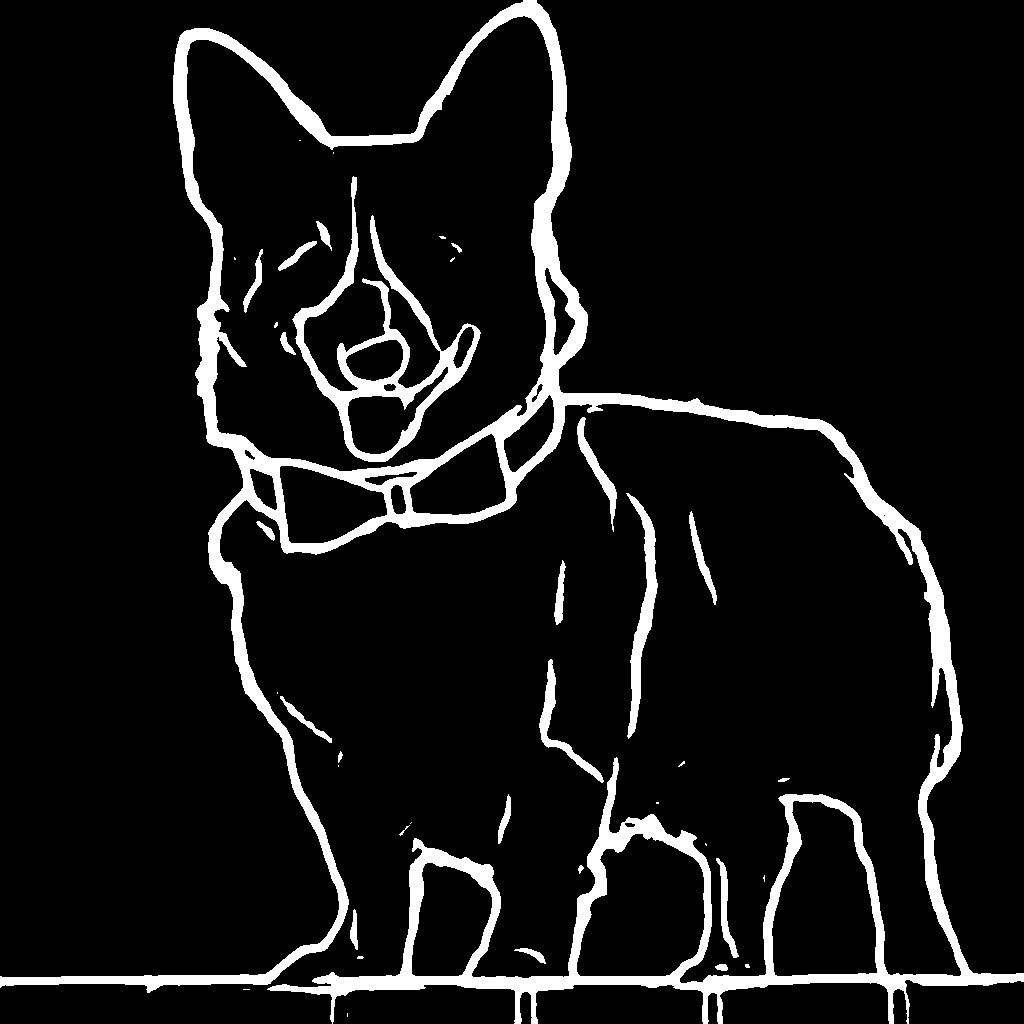

In [3]:
from diffusers.utils import load_image

image_sketch = load_image("https://huggingface.co/Adapter/t2iadapter/resolve/main/sketch.png").convert("L")
image_sketch

# Load Stable Diffusion XL and T2I Adapters
this will take a **LOT** of disk space

In [4]:
!du -hs models/* | egrep "stable|t2i"  

60G	models/stable-diffusion-xl-base-1.0
942M	models/t2iadapter


In [6]:
import torch
from diffusers import (
    T2IAdapter,
    StableDiffusionXLAdapterPipeline,
    DDPMScheduler,
    AutoencoderKL,
    EulerAncestralDiscreteScheduler
)
from diffusers.utils import load_image

model_id = "models/stable-diffusion-xl-base-1.0"
adapter = T2IAdapter.from_pretrained("models/t2iadapter", subfolder="sketch_sdxl_1.0", torch_dtype=torch.float16, adapter_type="full_adapter_xl")
scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionXLAdapterPipeline.from_pretrained(
    model_id, 
    adapter=adapter, 
    scheduler=scheduler,
    torch_dtype=torch.float16, 
    variant="fp16", 
).to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [7]:
!nvidia-smi

Thu Nov 23 18:45:24 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:01:00.0 Off |                  N/A |
| 30%   40C    P2             101W / 230W |   7346MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Feed the pipeline
* ```prompt```: What you would like to see
* ```negative_prompt```: What you **don't** want see (constant for me, regardless of prompt)
* ```guidance_scale```: How much emphasis to put on prompt (as opposed to sketch); range: no idea, default 7.5, always worked fine for me, independent of prompt/sketch
* ```num_inference_steps```: Number of denoising steps, **the more the better the picture** (and the longer it takes). default: 50. Draft with 10, at 30+ you get a decent picture
* ```adapter_conditioning_scale```: Impact of adapter (ie. sketch) on image (range 0-1, default 1.0, my inital choice: 0.9).
* ```adapter_conditioning_factor```: To how many of the inital steps the adapter is applied (range 0-1, default 1.0, my inital choice: 0.9)

The last two parameters need the most tweaking. 

More: https://huggingface.co/docs/diffusers/main/en/api/pipelines/stable_diffusion/adapter#diffusers.StableDiffusionXLAdapterPipeline

  0%|          | 0/30 [00:00<?, ?it/s]

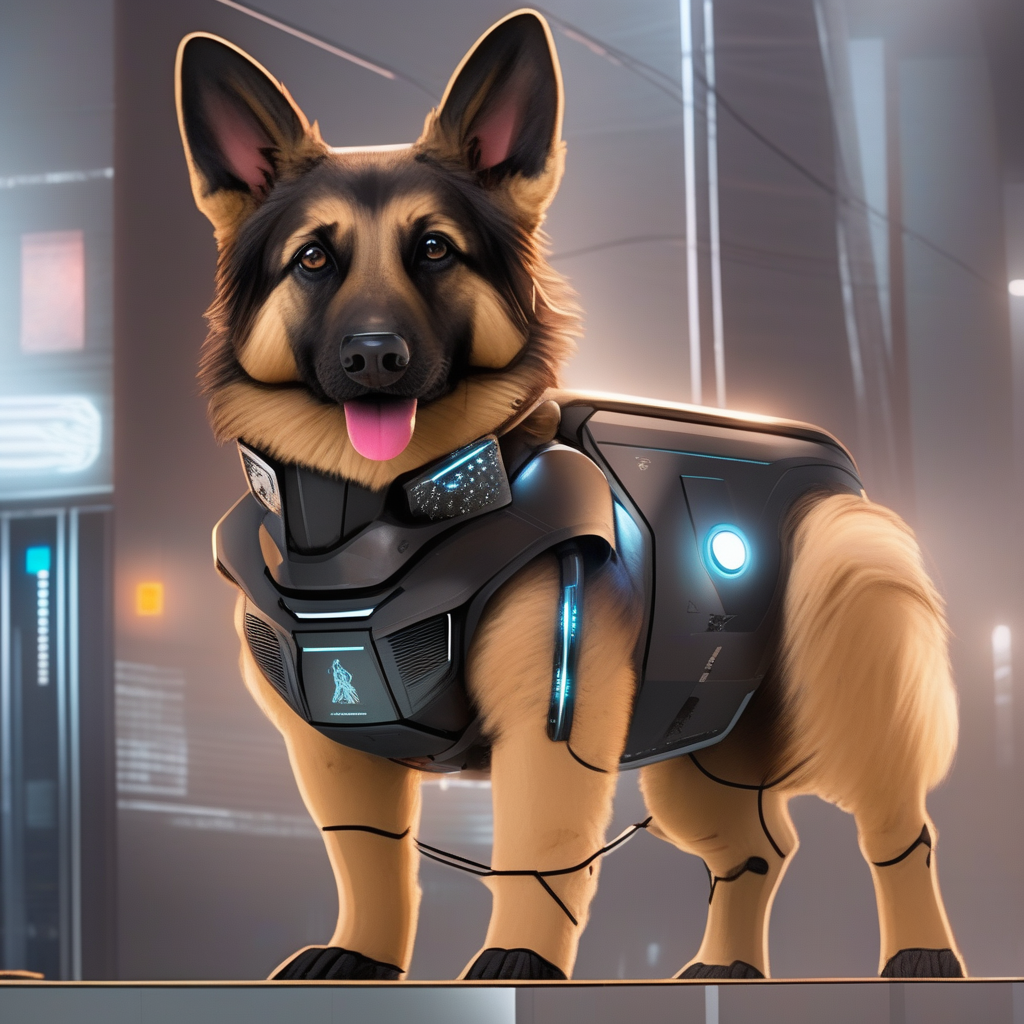

In [8]:
image=pipe(
        prompt="a robotic german shepherd from the future",
        negative_prompt=f"disfigured, extra digit, fewer digits, cropped, worst quality, low quality",
        image=image_sketch,
        guidance_scale=7.5,
        num_inference_steps=50,
        adapter_conditioning_scale=0.9,
        adapter_conditioning_factor=0.9,
    ).images[0]
image